In [9]:
# Import relevant libralies
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve
import pandas as pd
import dask.dataframe as dd
import numpy as np
from scipy.special import expit
import os
import matplotlib.pyplot as plt

In [3]:
#Load gisette
gisette_path = "https://archive.ics.uci.edu/ml/machine-learning-databases/gisette/"
gisette_train_x = dd.read_csv(os.path.join(gisette_path, 'GISETTE/gisette_train.data'),
                         delim_whitespace = True,
                         header = None,
                         blocksize = None).compute()

gisette_train_y = dd.read_csv(os.path.join(gisette_path, 'GISETTE/gisette_train.labels'),
                         delim_whitespace=True,
                         header = None,
                         blocksize = None).compute()

gisette_test_x = dd.read_csv(os.path.join(gisette_path, 'GISETTE/gisette_valid.data'),
                         delim_whitespace=True,
                         header = None, 
                         blocksize = None).compute()

gisette_test_y = dd.read_csv(os.path.join(gisette_path, 'gisette_valid.labels'),
                         delim_whitespace=True,
                         header = None,
                         blocksize = None).compute()

# Replace -1 with 0 so that it fits the slides
gisette_train_y.replace(-1, 0, inplace = True)
gisette_test_y.replace(-1, 0, inplace = True)


# Homework 3
Author: Mao Nishino

## Problem 1
Implement the Logistic Regression learning by gradient ascent as described in class.
Before using logistic regression, be sure to normalize the variables of the training set
to have zero mean and standard deviation 1, and to use the exact same transformation
on the test set, using the mean and standard deviation of the training set.
### Problem (a)
Using the Gisette data, train a logistic regressor on the training set, starting
with $w^{(0)} = 0$, with 300 gradient ascent iterations and shrinkage $λ = 0.0001$ in
the update equation:

$\displaystyle w^{(t+1)} \leftarrow w^{(t)} - \eta \lambda w^{(t)} + \frac{\eta}{N} \frac{\partial}{\partial w} L(w^{(t)})$

where $L(w^{(t)})$ s the log likelihood from page 7 of the Logistic Regression
slides. Observe that there is an extra factor of 1/N in the loss term compared to
the class notes.
Find a good learning rate η such that the log-likelihood converges in at most 300
iterations and is monotonically increasing. Plot the training log-likelihood vs
iteration number. Report in a table the misclassification error on the training and
test set. On the same graph, plot the Receiver Operating Characteristic (ROC)
curve of the obtained model on the training and test set.

In [5]:
# Define the gradient of the logistic loss
def grad(weights, X, y):
    wXT = np.matmul(weights, X.T)
    return np.matmul(y-expit(wXT), X)

# Define the logistic loss
def loss(weights, X, y):
    wXT = np.matmul(weights, X.T)
    y_new = np.where(wXT < 0, y, y-1)
    return np.dot(y_new, wXT) \
    -np.where(wXT < 0,
              np.log(1+np.exp(wXT)),
              np.log(1+np.exp(-wXT)),
              ).sum()

# Define parameters
eta = 1 # Learning Rate
N = gisette_train_x.shape[0] # Number of Samples
lamda = 0.0001 # Regularization Coefficient
eps = 0.1 # Convergence threshold
max_iter = 300 # the number of maximum iterations

# Use StandardScaler and add columns of 1
scl = StandardScaler()
scl.fit(gisette_train_x, gisette_train_y)
std_gisette_train_x = np.hstack([np.ones((gisette_train_x.shape[0], 1)),
                                scl.transform(gisette_train_x)])

# Initialization
w = np.zeros(std_gisette_train_x.shape[1])
previous_loss = loss(w, std_gisette_train_x, gisette_train_y.squeeze())
is_terminated_early = False
losses = []

# The gradient descent steps
for i in range(max_iter):
    w = w - eta*lamda*w+(eta/N)*grad(w, std_gisette_train_x, gisette_train_y.squeeze())
    loss_now = loss(w, std_gisette_train_x, gisette_train_y.squeeze())
    losses.append(loss_now)
    if np.abs(previous_loss - loss_now) < eps:
        is_terminated_early = True
        break
    previous_loss = loss_now

print('The number of iterations:', i, ', is_terminated_early:', is_terminated_early)
print('The maximal log-likelihood: ', loss_now)


The number of iterations: 79 , is_terminated_early: True
The maximal log-likelihood:  -10.233009067720928


The above shows that the learning rate of $1$ converges before the 300th interation. The following shows the plot between the number of iterations and the log-likelihood.

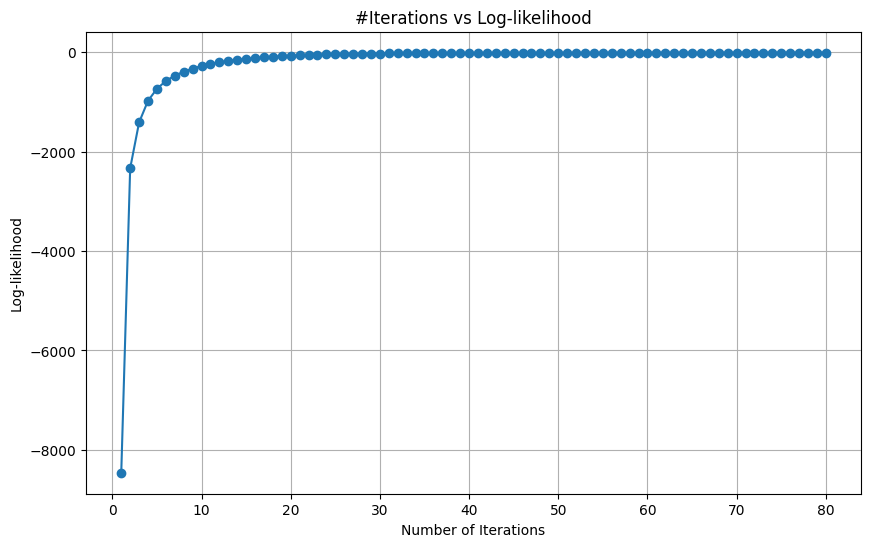

In [6]:
plt.figure(figsize = (10, 6))
plt.plot(range(1, len(losses)+1), losses, marker = 'o')
plt.xlabel('Number of Iterations')
plt.ylabel('Log-likelihood')
plt.title('#Iterations vs Log-likelihood')
plt.grid(True)
plt.show()

The following shows the training and the test misclassification error.

In [7]:
# Predicting function
def pred(weights, X):
    wXT = np.matmul(weights, X.T)
    return np.where(expit(wXT)>0.5, 1, 0)

# Scaling the test data
std_gisette_test_x = np.hstack([np.ones((gisette_test_x.shape[0], 1)),
                                scl.transform(gisette_test_x)])

# Make predictions
train_pred = pred(w, std_gisette_train_x)
test_pred = pred(w, std_gisette_test_x)

train_error = 1-accuracy_score(gisette_train_y, train_pred)
test_error = 1-accuracy_score(gisette_test_y, test_pred)

# Put it in a DataFrame so that it looks nicer
table = {
    'Training Error' : [train_error],
    'Test Error' : [test_error]
}

df = pd.DataFrame(table)
df

,Training Error,Test Error
0,0.0,0.021


The following shows the ROC curve of the model.

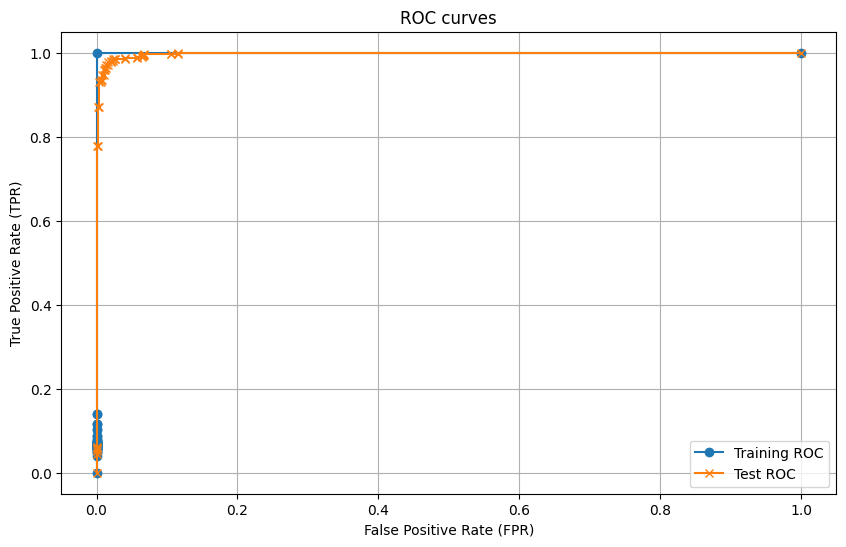

In [12]:
def pred_prob(weights, X):
    wXT = np.matmul(weights, X.T)
    return expit(wXT)

# Scaling the test data
std_gisette_test_x = np.hstack([np.ones((gisette_test_x.shape[0], 1)),
                                scl.transform(gisette_test_x)])

# Make predictions
train_pred = pred_prob(w, std_gisette_train_x)
test_pred = pred_prob(w, std_gisette_test_x)

fpr_train, tpr_train, thr = roc_curve(gisette_train_y, train_pred)
fpr_test, tpr_test, thr = roc_curve(gisette_test_y, test_pred)

# Plot ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, marker = 'o', label = 'Training ROC')
plt.plot(fpr_test, tpr_test, marker = 'x', label = 'Test ROC')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.title('ROC curves')
plt.grid(True)
plt.show()